*RECOMMENDATION SYSTEM*
    
BUILD A RECOMMENDATION SYSTEM
USING COLLABORATIVE FILTERING
OR MATRIX FACTORIZATION
TECHNIQUES.

DELIVERABLE: A NOTEBOOK OR APP
SHOWCASING RECOMMENDATION
RESULTS AND EVALUATION METRICS.

In [16]:
%pip uninstall -y numpy pandas scikit-surprise
%pip install numpy==1.26.4
%pip install pandas
%pip install scikit-surprise

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.3
Uninstalling pandas-2.2.3:
  Successfully uninstalled pandas-2.2.3
Found existing installation: scikit-surprise 1.1.4
Uninstalling scikit-surprise-1.1.4:
  Successfully uninstalled scikit-surprise-1.1.4
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 9.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
seaborn 0.13.2 requires pandas>=1.2, which is not installed.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 8.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
  Using cached scikit_surprise-1.1.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

In [2]:
# You can download the dataset from https://grouplens.org/datasets/movielens/
ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')

# Check structure
print("Ratings:\n", ratings.head())
print("Movies:\n", movies.head())
print("Ratings Shape:", ratings.shape)
print("Movies Shape:", movies.shape)

Ratings:
    userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
Movies:
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
Ratings Shape: (100836, 4)
Movies Shape: (9742, 3)


Nulls in Ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Nulls in Movies:
 movieId    0
title      0
genres     0
dtype: int64


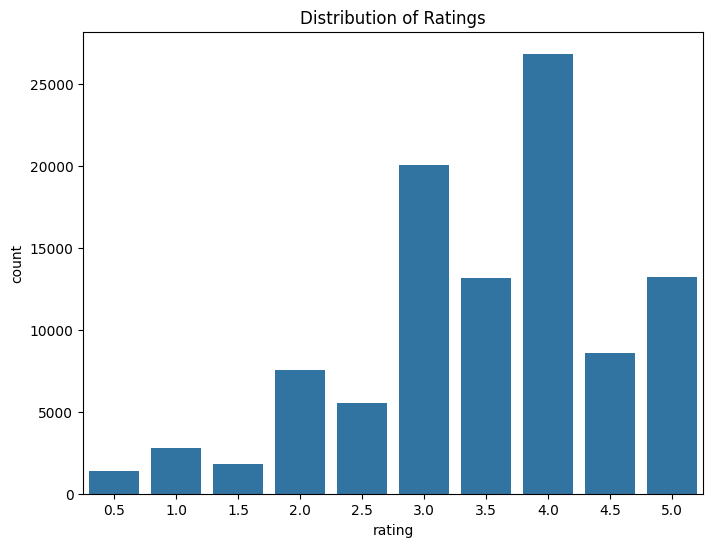

In [3]:
# Null check
print("Nulls in Ratings:\n", ratings.isnull().sum())
print("Nulls in Movies:\n", movies.isnull().sum())

# Distribution of ratings
plt.figure(figsize=(8,6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.show()

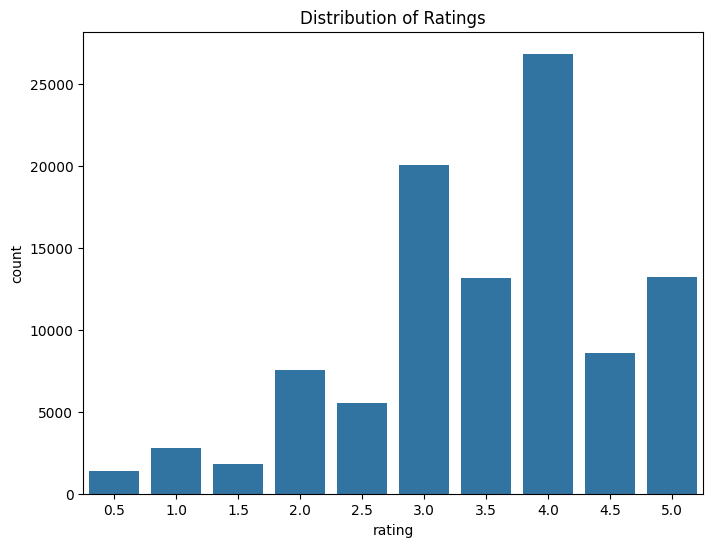

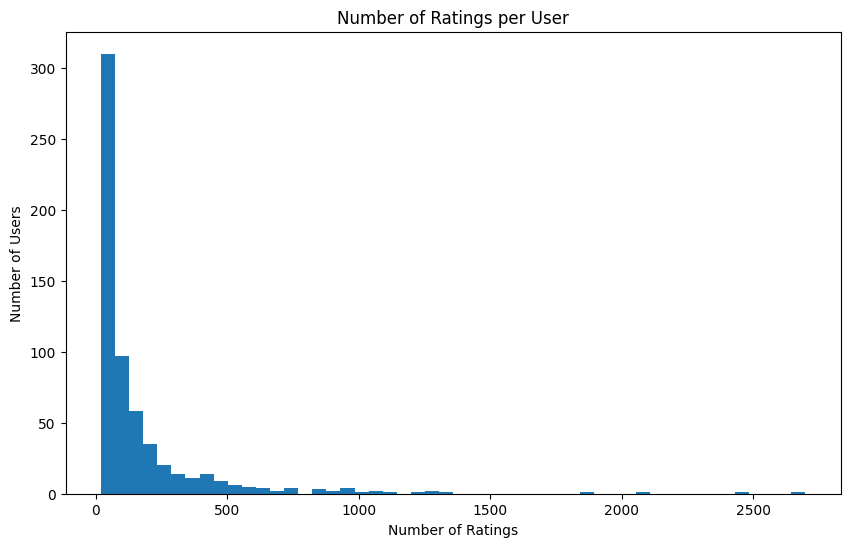

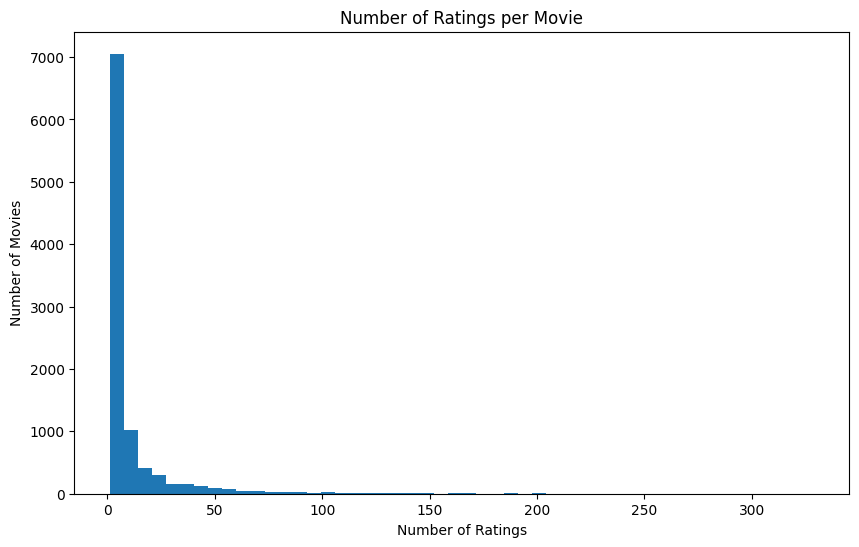

In [4]:
plt.figure(figsize=(8,6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.show()

plt.figure(figsize=(10,6))
ratings['userId'].value_counts().plot(kind='hist', bins=50)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

plt.figure(figsize=(10,6))
ratings['movieId'].value_counts().plot(kind='hist', bins=50)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()


In [5]:
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')
user_item_matrix_filled = user_item_matrix.fillna(0)

user_similarity = cosine_similarity(user_item_matrix_filled)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)


In [6]:
def get_user_based_recommendations(user_id, top_n=5):
    similarities = user_similarity_df.loc[user_id]
    weighted_sum = np.dot(similarities, user_item_matrix_filled)
    sum_of_similarities = np.sum(np.abs(similarities))
    predicted_ratings = weighted_sum / sum_of_similarities
    predicted_ratings = pd.Series(predicted_ratings, index=user_item_matrix.columns)

    already_rated = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    predicted_ratings = predicted_ratings.drop(already_rated, errors='ignore')

    top_movies = predicted_ratings.sort_values(ascending=False).head(top_n)
    return movies[movies['movieId'].isin(top_movies.index)].assign(predicted_rating=top_movies.values)

# Example
print("\nUser-Based Recommendations for User 1:")
print(get_user_based_recommendations(1))



User-Based Recommendations for User 1:
      movieId                                              title  \
277       318                   Shawshank Redemption, The (1994)   
507       589                  Terminator 2: Judgment Day (1991)   
659       858                              Godfather, The (1972)   
2078     2762                            Sixth Sense, The (1999)   
3638     4993  Lord of the Rings: The Fellowship of the Ring,...   

                    genres  predicted_rating  
277            Crime|Drama          2.622414  
507          Action|Sci-Fi          2.061920  
659            Crime|Drama          1.836914  
2078  Drama|Horror|Mystery          1.643315  
3638     Adventure|Fantasy          1.605043  


In [7]:
# Prepare data for SVD
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

print("\nEvaluation Metrics:")
accuracy.rmse(predictions)
accuracy.mae(predictions)

def get_svd_recommendations(user_id, top_n=5):
    user_rated = set(ratings[ratings['userId'] == user_id]['movieId'])
    all_movies = set(ratings['movieId'].unique())
    unrated_movies = all_movies - user_rated

    svd_preds = [algo.predict(user_id, movie_id) for movie_id in unrated_movies]
    top_preds = sorted(svd_preds, key=lambda x: x.est, reverse=True)[:top_n]

    movie_ids = [pred.iid for pred in top_preds]
    predicted_ratings = [pred.est for pred in top_preds]

    return movies[movies['movieId'].isin(movie_ids)].assign(predicted_rating=predicted_ratings)

# Example
print("\nSVD-Based Recommendations for User 1:")
print(get_svd_recommendations(1)['title'])


Evaluation Metrics:
RMSE: 0.8804
MAE:  0.6769

SVD-Based Recommendations for User 1:
277              Shawshank Redemption, The (1994)
596    Ghost in the Shell (Kôkaku kidôtai) (1995)
686                            Rear Window (1954)
896        One Flew Over the Cuckoo's Nest (1975)
906                     Lawrence of Arabia (1962)
Name: title, dtype: object


2025-04-21 10:38:04.349 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 10:38:04.490 
  command:

    streamlit run /Users/hm/Library/Python/3.12/lib/python/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-04-21 10:38:04.494 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 10:38:04.502 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 10:38:04.503 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 10:38:04.504 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 10:38:04.508 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 10:38:04.511 Session sta